# MIE524 - Assignment 2
Please complete this notebook for Assignment 2.

### Setup

In [12]:
## imports
!pip install pyspark

import pandas as pd
import numpy as np

#importing some Extra libraries
from sklearn import tree
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import math
from sklearn.ensemble import GradientBoostingRegressor
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.sql import SparkSession

import gc
import time


## Q1 - Gradient Boosted Trees
Complete below code. Please do not change class and function names. You may create additional functions or define additional parameters.

### Data

In [13]:
recipe_data_path = "/content/recipes.csv"# POINT TO YOUR FILE
recipe_data = pd.read_csv(recipe_data_path)

### Model

In [14]:
# Please use the below square loss for your gradient boosted tree implementation

class SquareLoss():
    def __init__(self): pass

    def loss(self, y, y_pred):
        return 0.5 * np.power((y - y_pred), 2)

    def gradient(self, y, y_pred):
        return -(y - y_pred)

In [15]:
''' Implement your own gradient boosted trees regressor from scratch.
    You may use scikit-learn's implementation of decision trees '''

class my_GradientBoosting(object):
    """Super class of GradientBoostingClassifier and GradientBoostinRegressor.
    Uses a collection of regression trees that trains on predicting the gradient
    of the loss function.

    Parameters:
    -----------
    n_estimators: int
        The number of classification trees that are used.
    learning_rate: float
        The step length that will be taken when following the negative gradient during
        training.
    min_samples_split: int
        The minimum number of samples needed to make a split when building a tree.
    min_impurity: float
        The minimum impurity required to split the tree further.
    max_depth: int
        The maximum depth of a tree.
    regression: boolean
        True or false depending on if we're doing regression or classification.
    """
    def __init__(self, n_estimators, learning_rate, min_samples_split,
                 min_impurity, max_depth, regression):

        # YOUR CODE HERE
        #Declaring Hyperparameters
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.min_samples_split = min_samples_split
        self.min_impurity = min_impurity
        self.max_depth = max_depth
        self.regression = regression #True / False
        self.trees = []

        #Adding multiple trees
        for i in range(self.n_estimators):
          if self.regression == False:
            #Classification Task
            raise ValueError("Classification Task is yet to be implemented")
          else:
            #Regression Task
            t = tree.DecisionTreeRegressor(min_samples_split=self.min_samples_split,
                                           min_impurity_decrease=self.min_impurity,
                                           max_depth=self.max_depth,
                                           )
            self.trees.append(t)
            self.loss = SquareLoss()



    def fit(self, X, y):

        # YOUR CODE HERE
        #Initial Prediction
        self.first = np.mean(y, axis = 0)
        y_pred = np.full(np.shape(y), self.first)

        for i in range(self.n_estimators):
          #Computing Gradient from Last prediction
          gradient = self.loss.gradient(y,y_pred)
          #Fit the current tree with the negative gradient (Fixing error from last prediction)
          self.trees[i].fit(X,-gradient)

          #Compute the new prediction
          new_pred = self.trees[i].predict(X)
          y_pred = y_pred + (self.learning_rate*new_pred)

    def predict(self, X):

        # YOUR CODE HERE
        #Regression
        #Initial prediction
        y_pred = np.full(X.shape[0], self.first)

        for i in range(self.n_estimators):
          y_pred = y_pred + (self.learning_rate*self.trees[i].predict(X))

        #Classification - yet to be defined

        return y_pred #Final Prediction



In [16]:
class my_GradientBoostingRegressor(my_GradientBoosting):
    def __init__(self, n_estimators=200, learning_rate=0.5, min_samples_split=2,
                 min_var_red=1e-7, max_depth=4, debug=False):

        # YOUR CODE HERE
        super(my_GradientBoostingRegressor,self).__init__(
            n_estimators = n_estimators,
            learning_rate = learning_rate,
            min_samples_split = min_samples_split,
            min_impurity = min_var_red,
            max_depth = max_depth,
            regression = True
        )

In [17]:
class my_RandomForestRegressor(object):
    """Random Forest regressor. Uses a collection of regression trees that
    trains on random subsets of the data using a random subsets of the features.

    Parameters:
    -----------
    n_estimators: int
        The number of classification trees that are used.
    max_features: int
        The maximum number of features that the classification trees are allowed to
        use.
    min_samples_split: int
        The minimum number of samples needed to make a split when building a tree.
    min_impurity_decrease: float
        A node will be split if this split induces a decrease of the impurity
        greater than or equal to this value.
    max_depth: int
        The maximum depth of a tree.
    n_samples: int
        The number of samples in each tree is max_samples * X.shape[0].
    """

    def __init__(self, n_estimators=200, max_features=None, min_samples_split=2,
                    min_impurity_decrease=0, max_depth=None, n_samples = 1):

        # YOUR CODE HERE
      #Declaring Hyperparameters
      self.n_estimators = n_estimators
      self.max_features = max_features
      self.min_samples_split = min_samples_split
      self.min_impurity_decrease = min_impurity_decrease
      self.max_depth = max_depth
      self.n_samples = n_samples
      self.trees = []

      #Adding trees to the forest
      for i in range(n_estimators):
          t = tree.DecisionTreeRegressor(min_samples_split=self.min_samples_split,
                                            min_impurity_decrease=self.min_impurity_decrease,
                                            max_depth=self.max_depth)
          self.trees.append(t)

    def fit(self,X,Y):
      train_sets = []
      #Bagging
      for i in range(self.n_estimators):
          temp = pd.concat([X,Y], axis=1).sample(frac=self.n_samples,replace=True,random_state=0)
          train_sets.append([temp.drop('rating', axis=1), temp[['rating']]])

      all_features = list(X.columns) #Get the list of columns

      #Feature bagging
      if self.max_features == None:
          self.max_features = int(math.sqrt(len(all_features)))

      for i in range(self.n_estimators):
          selected_features = np.random.choice(all_features, size=self.max_features, replace=True)
          x = train_sets[i][0][selected_features]
          y = train_sets[i][1]
          self.trees[i].features = selected_features #Save the randomed features used
          self.trees[i].fit(x,y)

    def predict(self, X):
      predictions = [] #Store prediction from all the trees
      for i in range(self.n_estimators):
          tree_features = self.trees[i].features
          predictions.append(self.trees[i].predict(X[tree_features]))
      final_prediction = np.mean(predictions, axis=0) #Compute the mean across all trees
      return final_prediction


### Model fitting and evaluation
Please use the below cells to train and evaluate your model on the test data.

a)

In [18]:
recipe_data = recipe_data.drop("title",axis = 1) #Dropping string column
recipe_data = recipe_data.dropna()

In [19]:
#X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
train_data, test_data = train_test_split(recipe_data, test_size=0.2, random_state=42)
X_train = train_data.drop("rating", axis = 1)
X_test = test_data.drop("rating", axis=1)
y_train = train_data['rating']
y_test = test_data['rating']
Y_test = y_test.to_numpy().reshape(-1)



In [20]:
GBR = my_GradientBoostingRegressor(n_estimators=100, max_depth=3)

My_start_time = time.time()
GBR.fit(X_train, y_train)
My_end_time = time.time()

My_training_time = My_end_time - My_start_time #Training time

b)

In [21]:
def get_rmse(Y_pred,Y_test):
  se = (Y_pred-Y_test)**2
  rmse = math.sqrt(np.sum(se)/len(Y_pred))
  return rmse

In [22]:
y_pred = GBR.predict(X_test)
Y_pred = y_pred.reshape(-1)

rmse = get_rmse(Y_pred,Y_test)
print(f"Test RMSE = {rmse}")


Test RMSE = 1.1777854220163337


c)

In [23]:
#'.' and ',' in column names seem to cause some problem, when using VectorAssembler
spark = SparkSession.builder.getOrCreate()

spark_train_data = spark.createDataFrame(train_data)
spark_train_data = spark_train_data.withColumnRenamed("washington, d.c.", "washington_dc")
spark_train_data = spark_train_data.withColumnRenamed("no meat, no problem", "no meat_no problem")
spark_train_data = spark_train_data.withColumnRenamed("st. louis", "st_louis")
spark_train_data = spark_train_data.withColumnRenamed("st. patrick's day", "st_patrick's day")



spark_test_data = spark.createDataFrame(test_data)
spark_test_data = spark_test_data.withColumnRenamed("washington, d.c.", "washington_dc")
spark_test_data = spark_test_data.withColumnRenamed("no meat, no problem", "no meat_no problem")
spark_test_data = spark_test_data.withColumnRenamed("st. louis", "st_louis")
spark_test_data = spark_test_data.withColumnRenamed("st. patrick's day", "st_patrick's day")


feature_columns = [col for col in spark_train_data.columns if col != 'rating']


assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
spark_train_data = assembler.transform(spark_train_data)
spark_test_data = assembler.transform(spark_test_data)

In [24]:
#Parameter used in my gradient boosted tree = n_estimators=100, learning_rate=0.5, min_samples_split=2, min_var_red=1e-7, max_depth=3, debug=False
#scikit-learn's tree
sk_tree = GradientBoostingRegressor(n_estimators=100,
                                     learning_rate=0.5,
                                     min_samples_split=2,
                                     min_impurity_decrease=1e-7,
                                     max_depth=3,
                                     random_state=0)

#Spark's tree
spark_train_data.cache()
spark_tree = GBTRegressor(labelCol="rating", featuresCol="features",
                           maxIter=100,
                           stepSize=0.5,
                           minInstancesPerNode=2,
                           minInfoGain=1e-7,
                           maxDepth=3)

#scikit-learn's tree fitting
sk_start_time = time.time()
sk_tree.fit(X_train,y_train)
sk_end_time = time.time()
sk_training_time = sk_end_time - sk_start_time

#Spark's tree fitting
#pipeline = Pipeline(stages=[assembler, spark_tree])
spark_start_time = time.time()
spark_model = spark_tree.fit(spark_train_data)
spark_end_time = time.time()
spark_training_time = spark_end_time - spark_start_time

#Evaluating performance on test set
sk_y_pred = sk_tree.predict(X_test)
sk_Y_pred = sk_y_pred.reshape(-1)
sk_rmse = get_rmse(sk_Y_pred,Y_test)

spark_y_pred = spark_model.transform(spark_test_data).select("prediction")
spark_Y_pred = spark_y_pred.toPandas()["prediction"].to_numpy()
spark_rmse = get_rmse(spark_Y_pred,Y_test)
print(f"My Decision Tree RMSE: {rmse}, Training Time:{My_training_time}")
print(f"scikit Decision Tree RMSE: {sk_rmse}, Training Time:{sk_training_time}")
print(f"Spark Decision Tree RMSE: {spark_rmse}, Training Time:{spark_training_time}")



My Decision Tree RMSE: 1.1777854220163337, Training Time:28.472116231918335
scikit Decision Tree RMSE: 1.1827506631727254, Training Time:9.921128988265991
Spark Decision Tree RMSE: 1.2241901863001672, Training Time:147.6804165840149


d)

In [25]:
print(len(list(X_train.columns)))

678


In [26]:
#Default Parameters of random forest = n_estimators=200, max_features=None, min_samples_split=2, min_impurity_decrease=0, max_depth=None, n_samples = 1
#Grid with 3 different sets of hyperparameters
grid = dict()
grid['n_estimators'] = [50,100,75]
grid['max_features'] = [15,None,20]
grid['min_samples_split'] = [1.0,2,3]
grid['min_impurity_decrease'] = [0,0,0]
grid['max_depth'] = [5,None,7]
grid['n_samples'] = [0.6,1,1]

for i in range(3):
  r_forest = my_RandomForestRegressor(n_estimators=grid['n_estimators'][i],
                                      max_features=grid['max_features'][i],
                                      min_samples_split=grid['min_samples_split'][i],
                                      min_impurity_decrease=grid['min_impurity_decrease'][i],
                                      max_depth=grid['max_depth'][i],
                                      n_samples=grid['n_samples'][i]
                                      )
  r_forest.fit(X_train,y_train)
  y_pred = r_forest.predict(X_test)
  rmse = get_rmse(y_pred,Y_test)
  print(f"Grid {i} : RMSE = {rmse}")

  #Free up memory
  del r_forest
  del y_pred
  gc.collect()


Grid 0 : RMSE = 1.2348194827253558
Grid 1 : RMSE = 1.2218958991516122
Grid 2 : RMSE = 1.226742916633319


Seen from part c) My gradient boosted tree is able to achieve

My Decision Tree RMSE: 1.1777854220163337, which is less than all 3 RMSEs of Random Forest; thus, achieving better prediction.

## Q2 - Autoencoder
Complete below code. Please do not change class and function names. You may create additional functions or define additional parameters.

### Data

In [27]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

# datasets
cifar_training_data = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

cifar_test_data = datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

# dataloader
batch_size = 100

train_loader = DataLoader(dataset=cifar_training_data,shuffle=True,batch_size=batch_size)
test_loader = DataLoader(dataset=cifar_test_data,shuffle=True,batch_size=batch_size)

100%|██████████| 170498071/170498071 [00:05<00:00, 29353865.14it/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


In [28]:
import torch
from torch import nn

class my_AutoEncoder(nn.Module):
    def __init__(self):
        super(my_AutoEncoder, self).__init__()

        self.latent_dim = 64

        self.encoder = self.build_encoder()
        self.decoder = self.build_decoder()

        # ADDITIONAL PARAMETERS

    def build_encoder(self):
        # build an encoder with two hidden layers

        # YOUR CODE HERE
        encoder = nn.Sequential(
          nn.Linear(3*32*32,512),
          nn.ReLU(),
          nn.Linear(512,self.latent_dim),
          nn.ReLU()
        )
        return encoder

    def build_decoder(self):
        # build a decoder with two hidden layers

        # YOUR CODE HERE
        decoder = nn.Sequential(
          nn.Linear(self.latent_dim,512),
          nn.ReLU(),
          nn.Linear(512,3*32*32),
          nn.Sigmoid()
        )
        return decoder

    def forward(self, x):
        return self.decoder(self.encoder(x))

    def train(self, n_epochs=5, save_interval=100):
        # YOUR CODE HERE
        criterion = nn.MSELoss()
        learning_rate = 0.001
        optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)
        loss_record = [] #record for every 100 batches


        for i in tqdm(range(n_epochs)):
          for j,(x,y) in enumerate(train_loader):
            y_pred = self.forward(x.reshape(-1,3*32*32))
            loss = criterion(y_pred,x.reshape(-1,3*32*32))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if (j+1) % save_interval == 0:
              loss_record.append(loss.item())
        return (loss.item(),loss_record)



####Q2 - a)

In [29]:
# DO NOT CHANGE this cell, this cell should run to train your autoencoder

my_ae = my_AutoEncoder()
outputs, losses = my_ae.train()

100%|██████████| 5/5 [02:53<00:00, 34.73s/it]


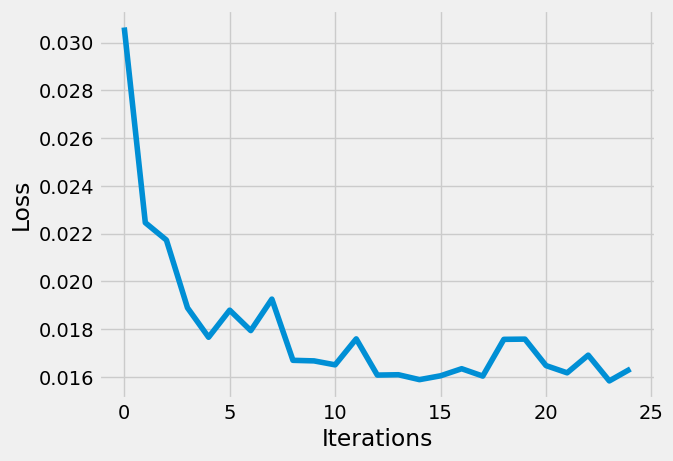

In [30]:
# Vizualize your training loss
import matplotlib.pyplot as plt
%matplotlib inline

# Defining the Plot Style
plt.style.use('fivethirtyeight')
plt.xlabel('Iterations')
plt.ylabel('Loss')

# Plotting the last 100 values
plt.plot(losses)

Please complete the written answer in the below text box.

In [31]:
loss_record = []
criterion = nn.MSELoss()

for x,y in test_loader:
  y_pred = my_ae.forward(x.reshape(-1,3*32*32))
  loss_record.append(criterion(y_pred,x.reshape(-1,3*32*32)).item())
test_mse = np.mean(loss_record) #The mean of test MSE across all batches
print(f"Last Train MSE: {outputs}")
print(f"Test MSE: {test_mse}")

Last Train MSE: 0.01633160002529621
Test MSE: 0.016111589623615145


The Train MSE, from the last batch, is 0.016

The Test MSE, computed as a mean from all the batches, is 0.016

####Q2 - b)

In [32]:
# YOUR CODE for extracting the latent representations for completing Q2 - b)
def extract_features(loader,ae=None):
  loader_x = []
  loader_y = []
  for x,y in loader:
    if ae == None:
      #No extraction -> Full information
      extracted_x = x.reshape(-1,3*32*32)
    else:
      #Extraction -> to latent_dim
      extracted_x = ae.encoder(x.reshape(-1,3*32*32)).detach()
    loader_x.append(extracted_x)
    loader_y.append(y)
  loader_x = torch.cat(loader_x, dim=0).numpy()
  loader_y = torch.cat(loader_y, dim=0).numpy()
  return (loader_x,loader_y)

train_x,train_y = extract_features(train_loader, my_ae)

print(train_x.shape)
print(train_y.shape)


(50000, 64)
(50000,)


In [33]:
from sklearn.ensemble import RandomForestClassifier

sk_clf = RandomForestClassifier(n_estimators = 20, max_features = 20,
                   min_samples_split = 2, min_impurity_decrease = 0,
                   max_depth = None, max_samples = 0.05)


# YOUR CODE for training the random forest model on the latent representations
from sklearn.metrics import f1_score, accuracy_score
sk_clf.fit(train_x,train_y)

test_x, test_y = extract_features(test_loader,my_ae)
pred_y = sk_clf.predict(test_x)

print("Test Report")
print(f"Accuracy: {accuracy_score(test_y, pred_y)}")
print(f"F1-score: {f1_score(test_y, pred_y, average='weighted')}")



Test Report
Accuracy: 0.3362
F1-score: 0.3339283991865731


In [34]:
pred_y_train = sk_clf.predict(train_x)
print("Train Report")
print(f"Accuracy: {accuracy_score(train_y, pred_y_train)}")
print(f"F1-score: {f1_score(train_y, pred_y_train, average='weighted')}")

Train Report
Accuracy: 0.4388
F1-score: 0.43766602850867725


The model is underfitting, I'll try to introduce some more complexity

In [35]:
adjusted_sk_clf = RandomForestClassifier(n_estimators = 200,
                                         max_features = "sqrt",
                                         min_samples_split = 2,
                                         max_depth = None,
                                         max_samples = 0.05
                                         )
adjusted_sk_clf.fit(train_x,train_y)
pred_y_train = adjusted_sk_clf.predict(train_x)
print("Train Report")
print(f"Accuracy: {accuracy_score(train_y, pred_y_train)}")
print(f"F1-score: {f1_score(train_y, pred_y_train, average='weighted')}")

Train Report
Accuracy: 0.5807
F1-score: 0.5788970901567125


In [36]:
pred_y = adjusted_sk_clf.predict(test_x)
print("Test Report")
print(f"Accuracy: {accuracy_score(test_y, pred_y)}")
print(f"F1-score: {f1_score(test_y, pred_y, average='weighted')}")



Test Report
Accuracy: 0.4001
F1-score: 0.3927509558463803


Using the model from the lab


In [37]:
unextracted_train_x = (extract_features(train_loader))[0]
print(unextracted_train_x.shape)

unextracted_test_x = (extract_features(test_loader))[0]
print(unextracted_test_x.shape)


(50000, 3072)
(10000, 3072)


In [38]:
#Train on Full information
lab_sk_clf = RandomForestClassifier(n_estimators = 20, max_features = 20,
                   min_samples_split = 2, min_impurity_decrease = 0,
                   max_depth = None, max_samples = 0.05)
lab_sk_clf.fit(unextracted_train_x,train_y)
pred_y_train = lab_sk_clf.predict(unextracted_train_x)
print("Train Report")
print(f"Accuracy: {accuracy_score(train_y, pred_y_train)}")
print(f"F1-score: {f1_score(train_y, pred_y_train, average='weighted')}")


Train Report
Accuracy: 0.24836
F1-score: 0.24608188811160162


In [39]:
pred_y = lab_sk_clf.predict(unextracted_test_x)
print("Test Report")
print(f"Accuracy: {accuracy_score(test_y, pred_y)}")
print(f"F1-score: {f1_score(test_y, pred_y, average='weighted')}")


Test Report
Accuracy: 0.0963
F1-score: 0.0943742415248395


Please complete the written answer in the below text box.

Random Forest + Autoencoder performs better, as Autoencoder captures the important features from the inputs, and reduces the dimensions of inputs; therefore, Random Forest is able to fit to the reduced data easier.

#### Q2 - c)

In [40]:
# YOUR CODE for changing latent space dimensions and retraining your autoencoder.
# Let's try 32, 128, 256
train_mse = []

for l in [32,128,256]:
  ae = my_AutoEncoder()
  ae.latent_dim = l #Set new latent_dim
  ae.encoder = ae.build_encoder() #Build encoder again to adjust for the change in latent_dim
  ae.decoder = ae.build_decoder() #Same applies to decoder
  outputs, losses = ae.train()
  train_mse.append(outputs)

  #Use autoencoder to extract features
  train_x = extract_features(train_loader, ae)[0]
  test_x = extract_features(test_loader, ae)[0]

  #Train on extracted features
  sk_clf.fit(train_x,train_y)
  pred_y = sk_clf.predict(test_x)

  #Report evaluated from test data
  print(f"{l}-dimension encoder Report")
  print(f"Accuracy: {accuracy_score(test_y, pred_y)}")
  print(f"F1-score: {f1_score(test_y, pred_y, average='weighted')}")
  print("====================")





100%|██████████| 5/5 [03:04<00:00, 36.83s/it]


32-dimension encoder Report
Accuracy: 0.1014
F1-score: 0.09966664210556753


100%|██████████| 5/5 [03:08<00:00, 37.75s/it]


128-dimension encoder Report
Accuracy: 0.1025
F1-score: 0.10001311023950916


100%|██████████| 5/5 [03:11<00:00, 38.27s/it]


256-dimension encoder Report
Accuracy: 0.0982
F1-score: 0.09671452460608365


Please complete the written answer in the below text box.

Let A > B means A has better performance than B.

64-dimension > 128-dimension > 32-dimension > 256-dimension